In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pylab import rcParams
# from sklearn.model_selection import GridSearchCV, train_test_split


warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(15, 7)})
sns.set_style('white')
pd.set_option('display.max_columns', 500)

###### Time Series Analysis

In [2]:
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')

df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()

In [3]:
train = df.iloc[:48]
test = df.iloc[48:]

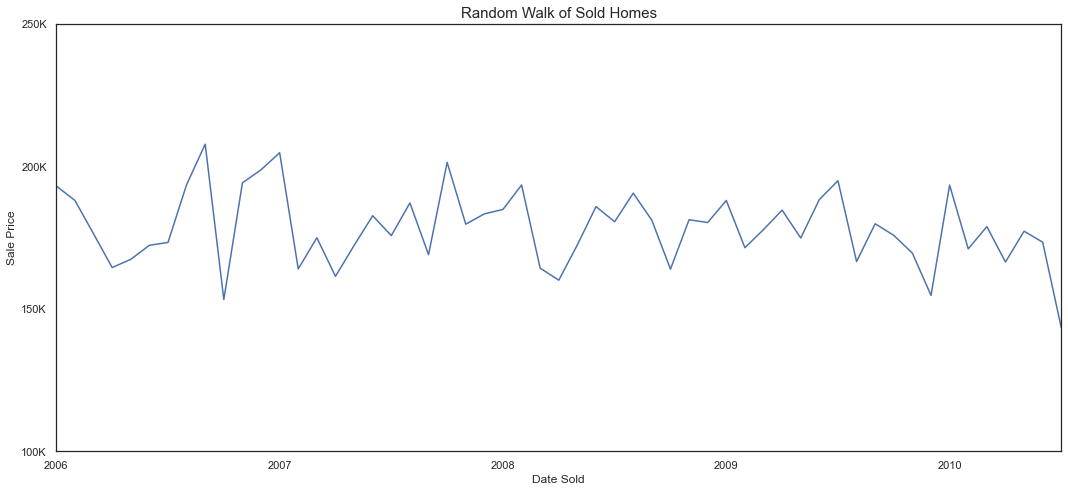

In [28]:
fig = df.plot(legend=False)
fig.set(xlabel='Date Sold',
        ylabel='Sale Price',
        xticks=['2006-01', '2007-01', '2008-01', '2009-01', '2010-01'],
        xticklabels=list(range(2006, 2011)),
        yticks=[1e5, 1.5e5, 2e5, 2.5e5],
        yticklabels=['100K', '150K', '200K', '250K'])
plt.title('Random Walk of Sold Homes', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Timeseries DateSold, Lineplot.png', dpi = 1000)
plt.show()

In [222]:
adf = sm.tsa.adfuller(df, regression='ct')
print(f'adf test: {adf[0]}, p-value: {adf[1]}')

# looks like we can reject the null hypothesis and continue with the test

adf test: -6.948276068898889, p-value: 1.8493823638383215e-08


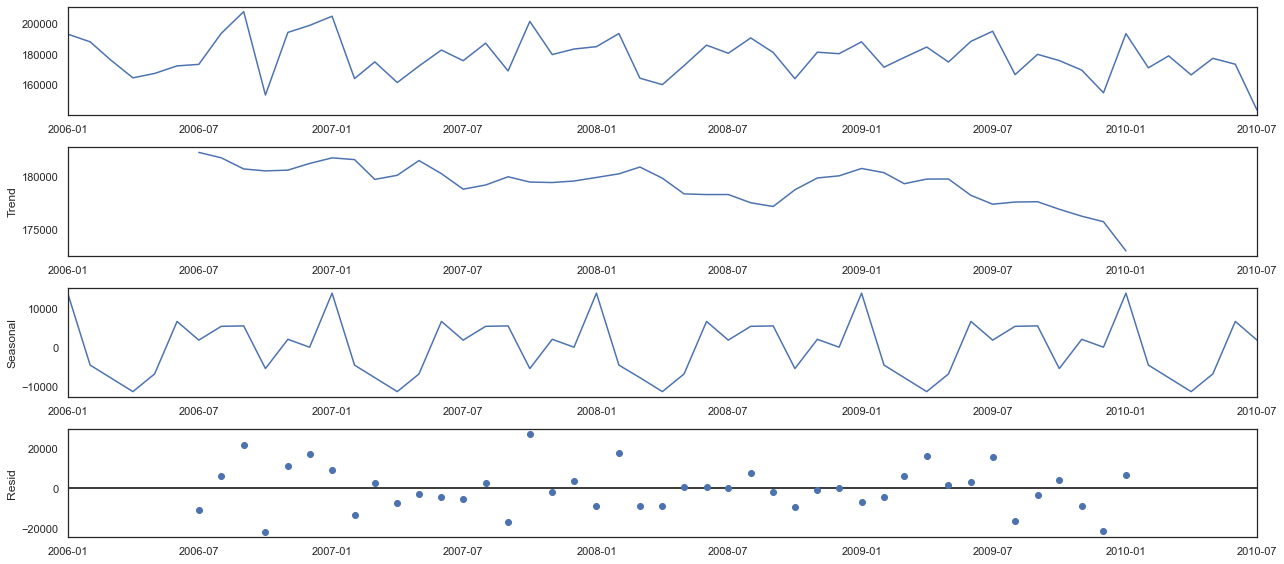

In [5]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

# there's a clear trend downwards -- this is probably due to the housing crisis
# we can also clearly see a seasonality trend
# residuals all look normalized, for the most part

In [78]:
# lets find the best parameters with the lowest AIC score and lowest MSE

optimal_sarima = 1e6
pdq = []
seasonal_pdq = []

for arima, sarima, aic in results:
    if aic < optimal_sarima:
        optimal_sarima = aic
        pdq = arima
        seasonal_pdq = sarima
    else:
        continue
        
print(f'arima: {pdq}, sarima: {seasonal_pdq}, AIC: {optimal_sarima}')

arima: (1, 1, 1), sarima: (1, 1, 1, 11), AIC: 10.0


In [79]:
results

[[(0, 0, 0), (0, 0, 0, 11), 1461.2175637434527],
 [(0, 0, 0), (0, 0, 1, 11), 1134.8815527826287],
 [(0, 0, 0), (0, 1, 0, 11), 948.358951451852],
 [(0, 0, 0), (0, 1, 1, 11), 989.7489615509239],
 [(0, 0, 0), (1, 0, 0, 11), 969.7167746878723],
 [(0, 0, 0), (1, 0, 1, 11), 950.1052599445668],
 [(0, 0, 0), (1, 1, 0, 11), 732.063663706013],
 [(0, 0, 0), (1, 1, 1, 11), 1134.5351507820199],
 [(0, 0, 1), (0, 0, 0, 11), 1398.94107388695],
 [(0, 0, 1), (0, 0, 1, 11), 1172.4780124532906],
 [(0, 0, 1), (0, 1, 0, 11), 927.939997920171],
 [(0, 0, 1), (0, 1, 1, 11), 688.6247435390446],
 [(0, 0, 1), (1, 0, 0, 11), 1151.0102541874485],
 [(0, 0, 1), (1, 0, 1, 11), 1100.9611257357187],
 [(0, 0, 1), (1, 1, 0, 11), 734.0934805006307],
 [(0, 0, 1), (1, 1, 1, 11), 1133.1462453928805],
 [(0, 1, 0), (0, 0, 0, 11), 1191.118882903548],
 [(0, 1, 0), (0, 0, 1, 11), 933.6381635713747],
 [(0, 1, 0), (0, 1, 0, 11), 955.6125294299012],
 [(0, 1, 0), (0, 1, 1, 11), 1303.608695713855],
 [(0, 1, 0), (1, 0, 0, 11), 957.09532

In [9]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5887      0.528     -1.116      0.265      -1.623       0.445
ma.L1          0.0422      0.597      0.071      0.944      -1.128       1.212
ar.S.L12      -0.5997      0.361     -1.662      0.097      -1.307       0.108
sigma2      3.357e+08   9.01e-10   3.72e+17      0.000    3.36e+08    3.36e+08


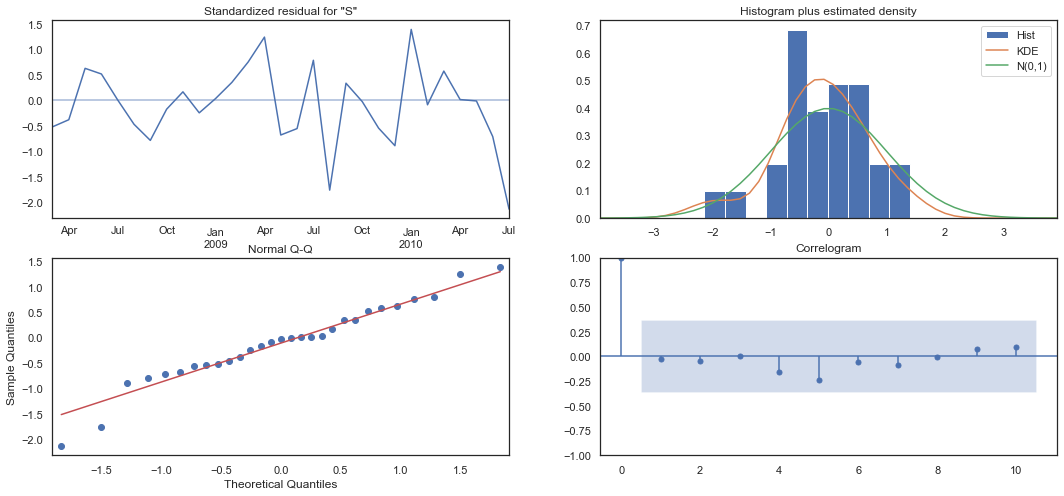

In [226]:
result.plot_diagnostics()
plt.show()

In [227]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5887      0.528     -1.116      0.265      -1.623       0.445
ma.L1          0.0422      0.597      0.071      0.944      -1.128       1.212
ar.S.L12      -0.5997      0.361     -1.662      0.097      -1.307       0.108
sigma2      3.357e+08   9.01e-10   3.72e+17      0.000    3.36e+08    3.36e+08


In [198]:
result = mod.fit(disp=False, return_params=True)

In [83]:
1.70393326e+08

170393326.0

In [90]:
mod.

{'trend': 0,
 'exog': 0,
 'ar': 1,
 'ma': 1,
 'seasonal_ar': 12,
 'seasonal_ma': 12,
 'reduced_ar': 13,
 'reduced_ma': 13,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [117]:
pred.predicted_mean

2009-06-01   -6.073850e+44
2009-07-01   -7.361718e+45
2009-08-01   -8.922659e+46
2009-09-01   -1.081457e+48
2009-10-01   -1.310764e+49
2009-11-01   -1.588692e+50
2009-12-01   -1.925550e+51
2010-01-01   -2.333834e+52
Freq: MS, Name: predicted_mean, dtype: float64

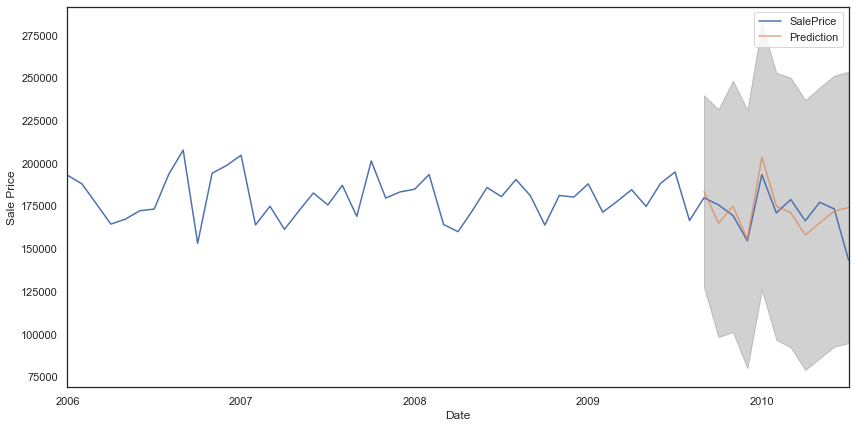

arima: (1, 1, 1), sarima: (1, 0, 1, 12), aic: 370.90910113060954, rmse = 13882.42137457328


In [142]:
pdq = (1, 1, 1)
PDQM = (1, 0, 1, 12)

mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)

pred = result.get_prediction(start=pd.to_datetime('2009-09-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = df.plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 7))
mse = ((df['2010-01-01':].squeeze() - pred.predicted_mean) ** 2).mean()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
plt.show()
print(f'arima: {pdq}, sarima: {PDQM}, aic: {result.aic}, rmse = {mse ** 0.5}')

In [98]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)

result = mod.fit(disp=False)
result.

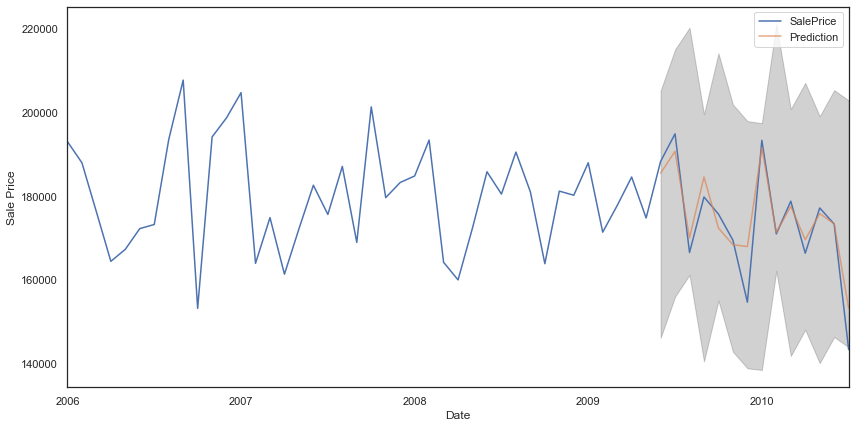

arima: (1, 1, 1), sarima: (1, 0, 1, 12), aic: 1212.1729363341087, rmse = 17805.812761652465


In [126]:
pdq = (1, 1, 1)
PDQM = (1, 0, 1, 12)

mod = sm.tsa.statespace.SARIMAX(df,
                                order=pdq,
                                seasonal_order=PDQM,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
result = mod.fit(disp=False)

pred = result.get_prediction(start=pd.to_datetime('2009-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.plot(label='Observed')

predicted_mean = pred.predicted_mean.shift(-1)
predicted_mean.iloc[13] = result.forecast(1)
predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 7))
mse = ((df['2010-01-01':].squeeze() - pred.predicted_mean) ** 2).mean()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
plt.show()
print(f'arima: {pdq}, sarima: {PDQM}, aic: {result.aic}, rmse = {mse ** 0.5}')

### Grid Search

In [103]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 11) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 11)
SARIMAX: (0, 0, 1) x (0, 1, 0, 11)
SARIMAX: (0, 1, 0) x (0, 1, 1, 11)
SARIMAX: (0, 1, 0) x (1, 0, 0, 11)


In [104]:
results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            trend_offset=2)
            result = mod.fit(disp=False)
            results.append([param, param_seasonal, result.aic])
            
        except:
            continue

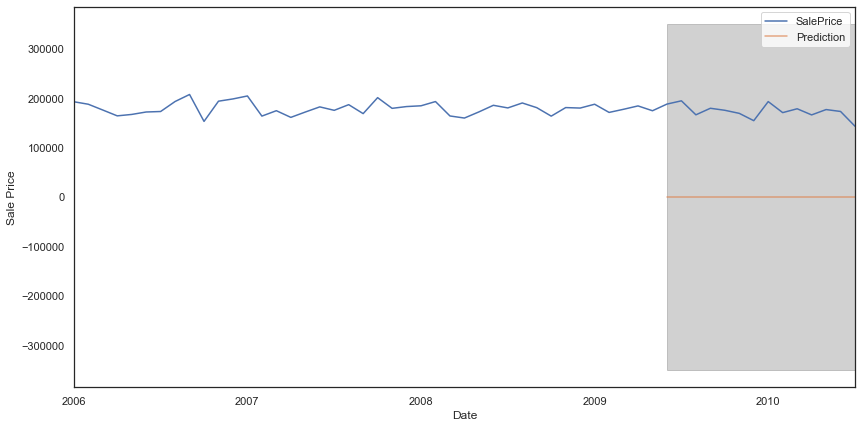

arima: (0, 0, 0), sarima: (0, 0, 0, 11), aic: 1461.2175637434527, rmse = 174318.42741606486


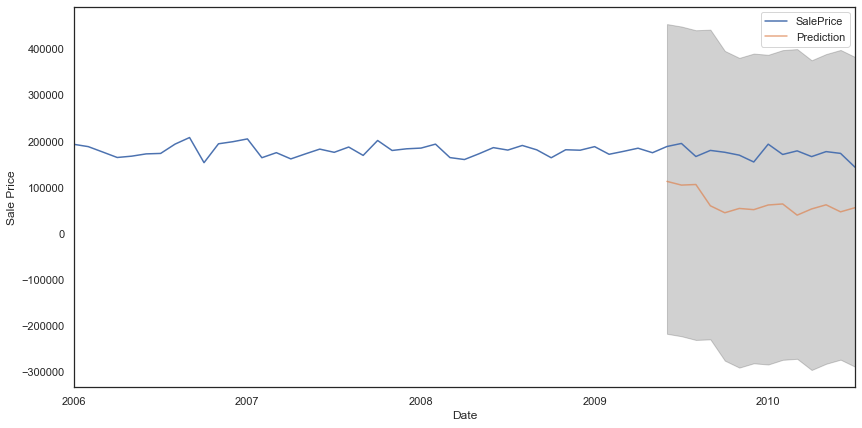

arima: (0, 0, 0), sarima: (0, 0, 1, 11), aic: 1134.8815527826287, rmse = 106637.28605118634


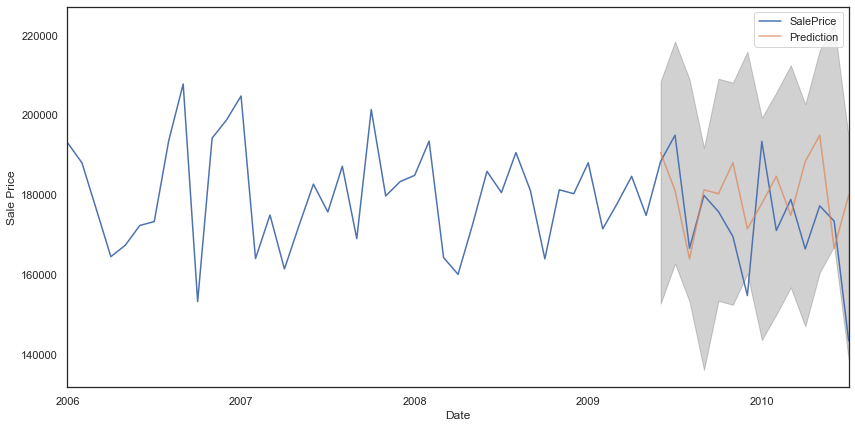

arima: (0, 0, 0), sarima: (0, 1, 0, 11), aic: 948.358951451852, rmse = 15935.472735144422


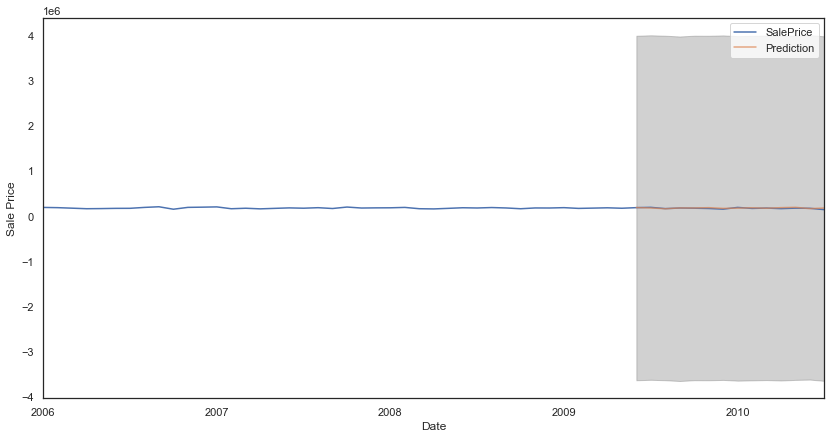

arima: (0, 0, 0), sarima: (0, 1, 1, 11), aic: 989.7489615509239, rmse = 15935.472735144816


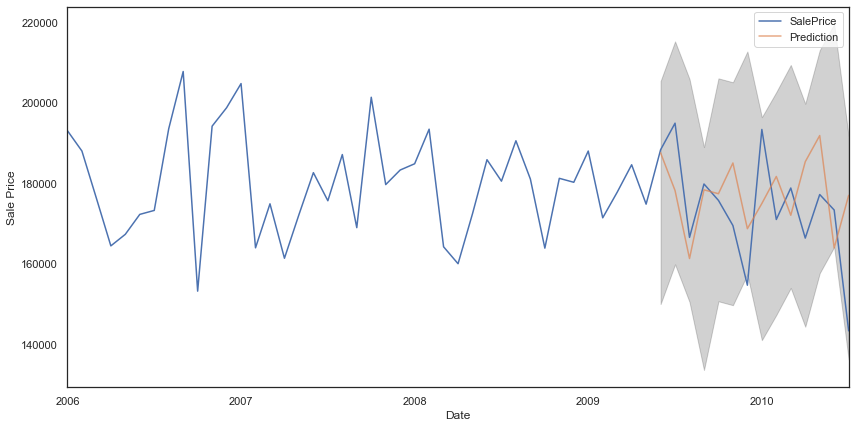

arima: (0, 0, 0), sarima: (1, 0, 0, 11), aic: 969.7167746878723, rmse = 14951.40945771141


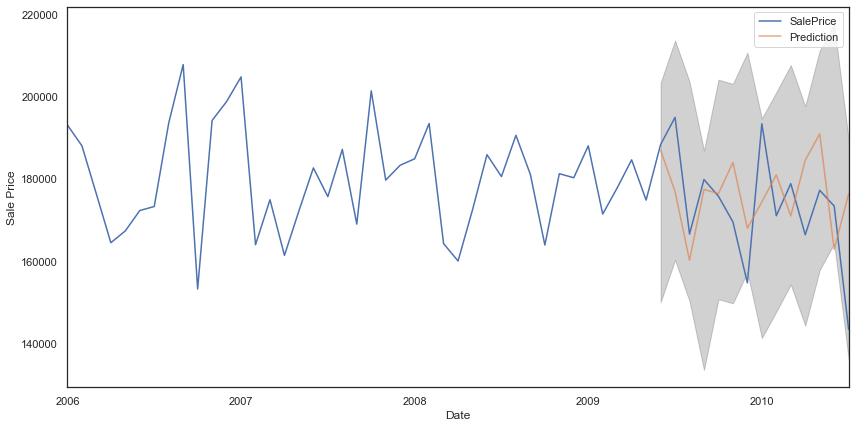

arima: (0, 0, 0), sarima: (1, 0, 1, 11), aic: 950.1052599445668, rmse = 14690.288717033163


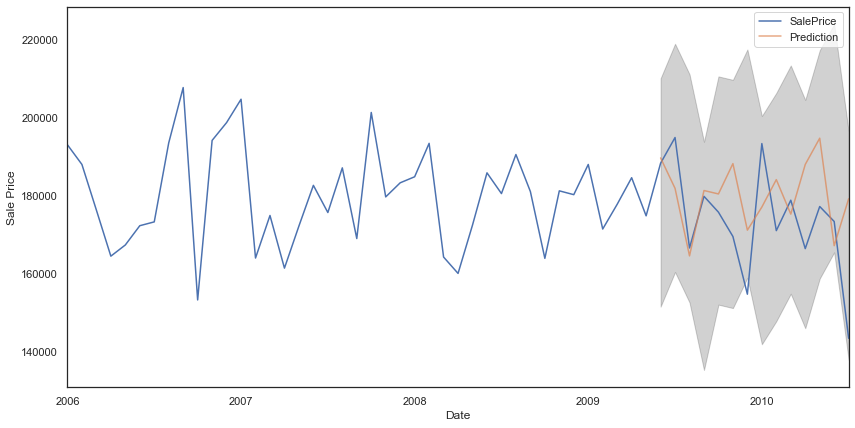

arima: (0, 0, 0), sarima: (1, 1, 0, 11), aic: 732.063663706013, rmse = 16040.454371548269


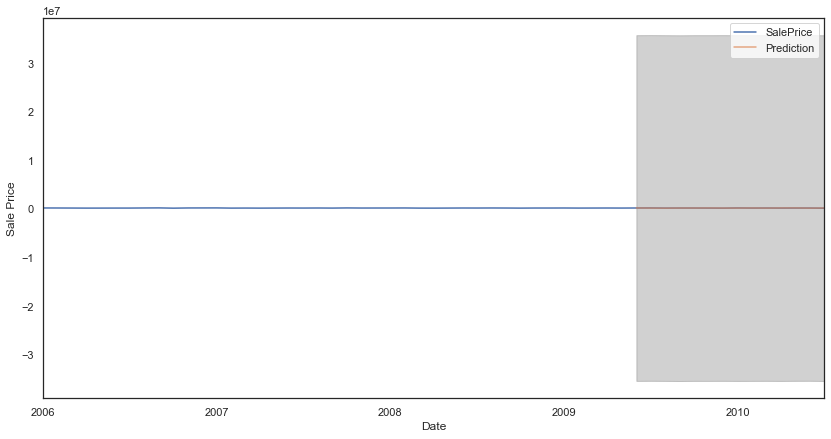

arima: (0, 0, 0), sarima: (1, 1, 1, 11), aic: 1134.5351507820199, rmse = 15683.418902790298


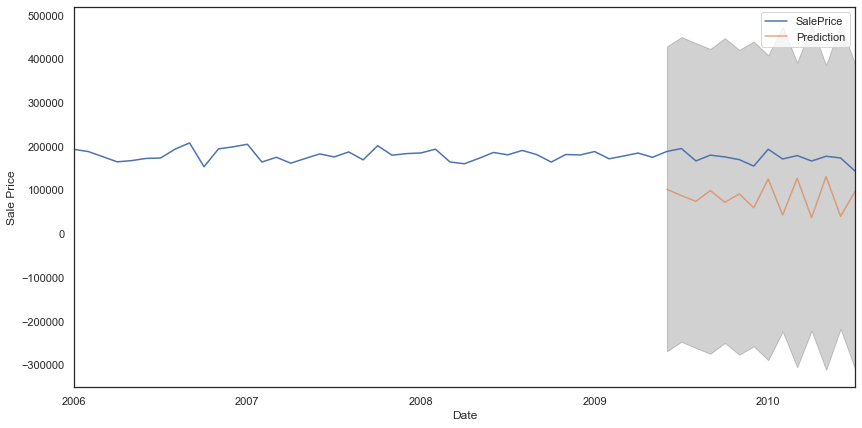

arima: (0, 0, 1), sarima: (0, 0, 0, 11), aic: 1398.94107388695, rmse = 96340.2129737103


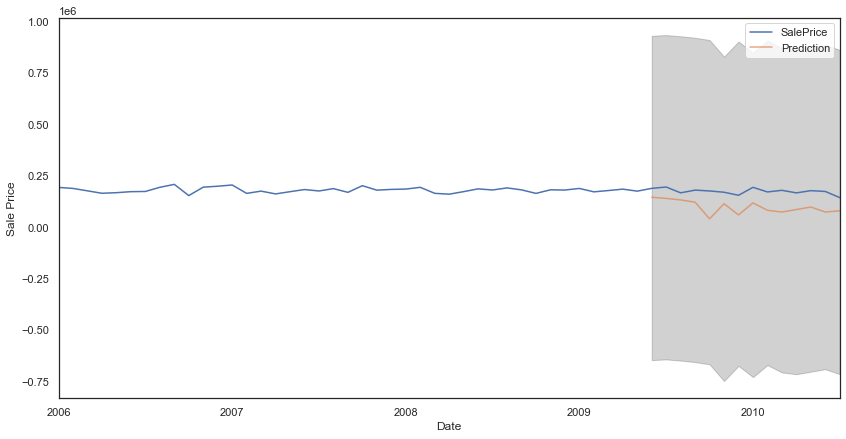

arima: (0, 0, 1), sarima: (0, 0, 1, 11), aic: 1172.4780124532906, rmse = 78877.73918959803


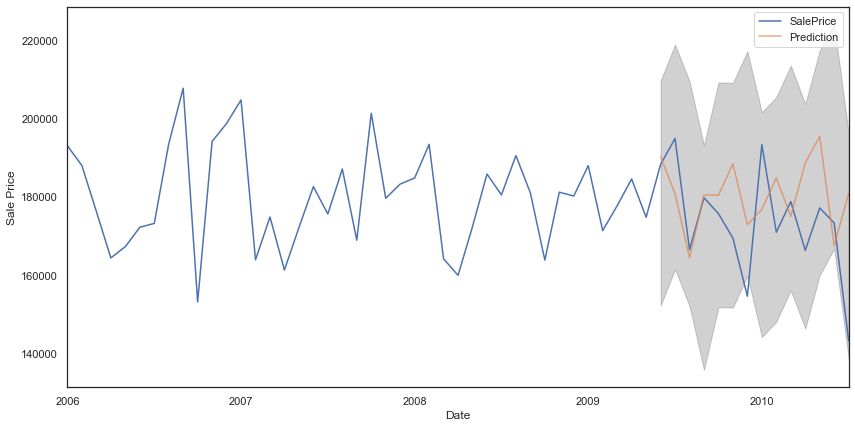

arima: (0, 0, 1), sarima: (0, 1, 0, 11), aic: 927.939997920171, rmse = 15959.24131452174


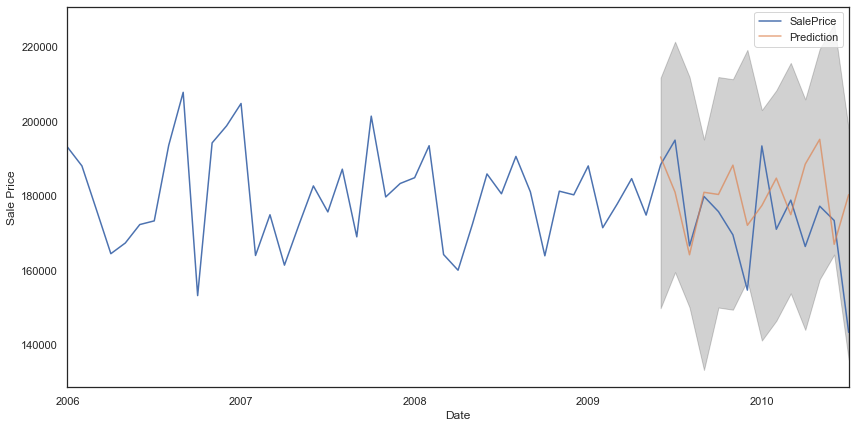

arima: (0, 0, 1), sarima: (0, 1, 1, 11), aic: 688.6247435390446, rmse = 15941.062963054701


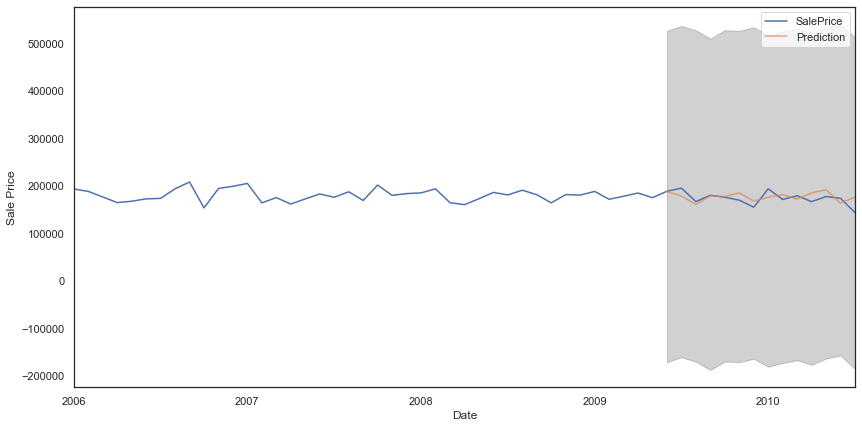

arima: (0, 0, 1), sarima: (1, 0, 0, 11), aic: 1151.0102541874485, rmse = 14961.046443152762


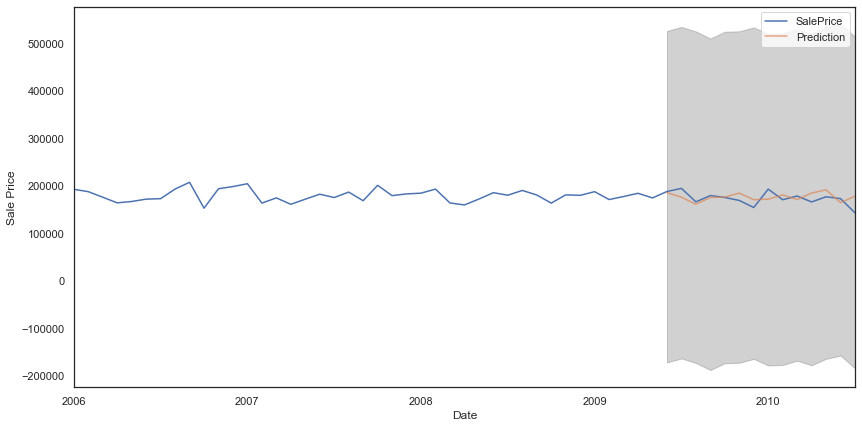

arima: (0, 0, 1), sarima: (1, 0, 1, 11), aic: 1100.9611257357187, rmse = 14642.215264812665


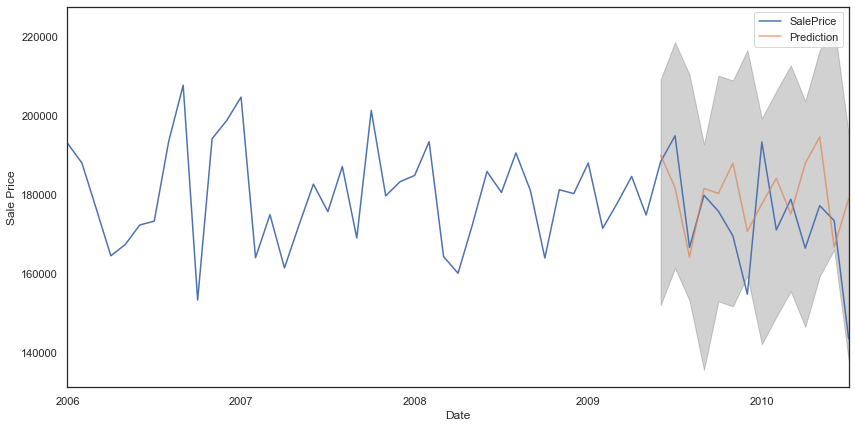

arima: (0, 0, 1), sarima: (1, 1, 0, 11), aic: 734.0934805006307, rmse = 16013.88979935507


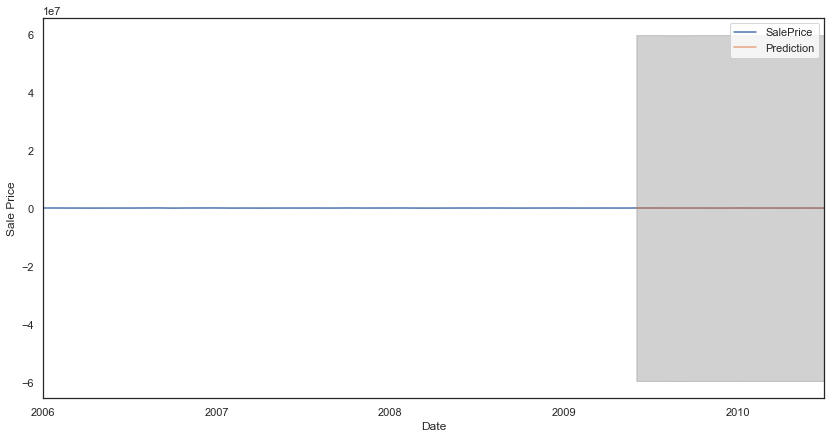

arima: (0, 0, 1), sarima: (1, 1, 1, 11), aic: 1133.1462453928805, rmse = 15689.864507020136


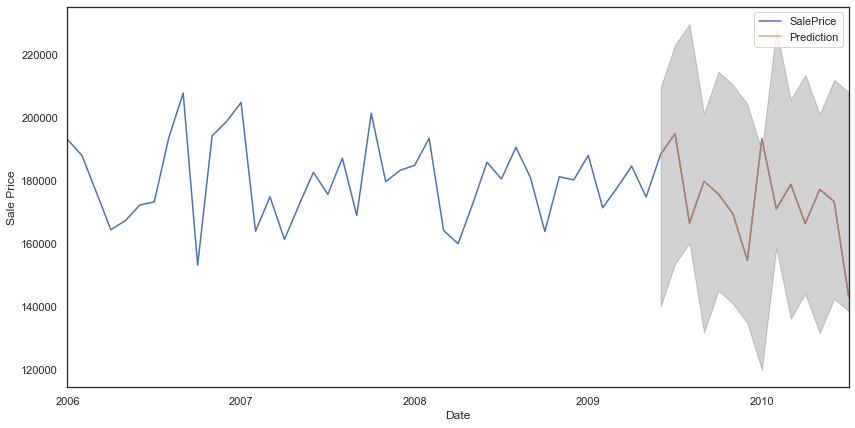

arima: (0, 1, 0), sarima: (0, 0, 0, 11), aic: 1191.118882903548, rmse = 18366.7470507678


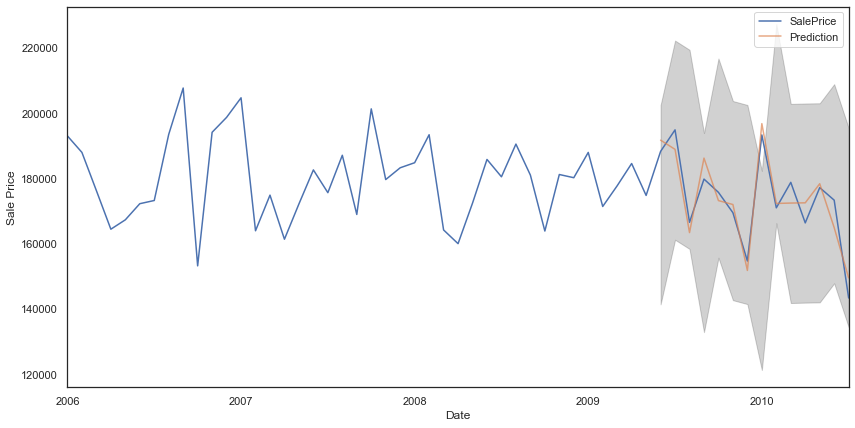

arima: (0, 1, 0), sarima: (0, 0, 1, 11), aic: 933.6381635713747, rmse = 17841.313436234974


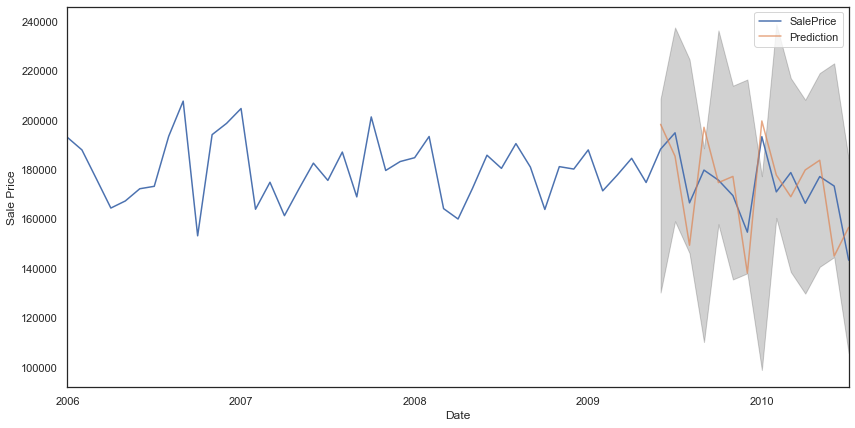

arima: (0, 1, 0), sarima: (0, 1, 0, 11), aic: 955.6125294299012, rmse = 21785.592367099583


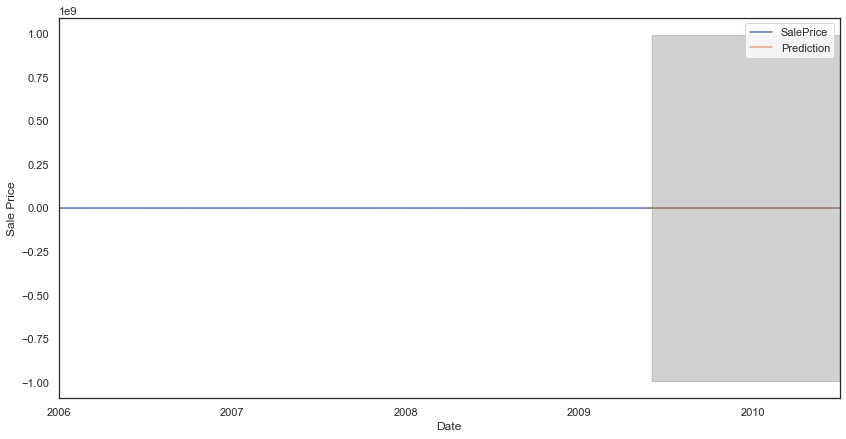

arima: (0, 1, 0), sarima: (0, 1, 1, 11), aic: 1303.608695713855, rmse = 21785.59236709954


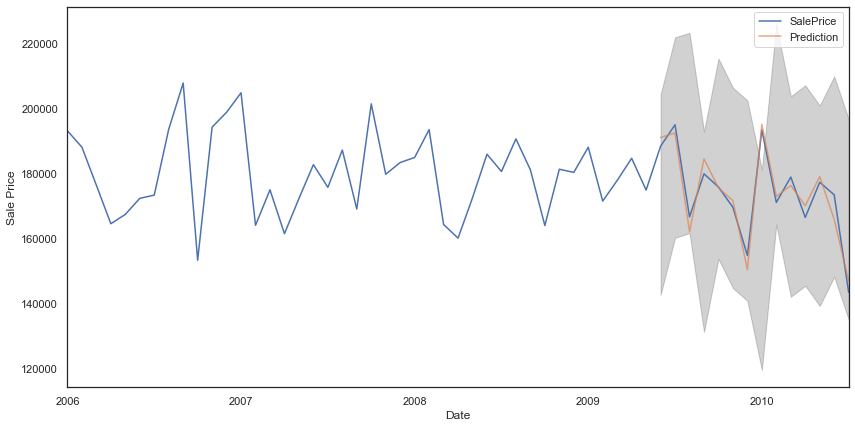

arima: (0, 1, 0), sarima: (1, 0, 0, 11), aic: 957.0953294030314, rmse = 18463.654458906774


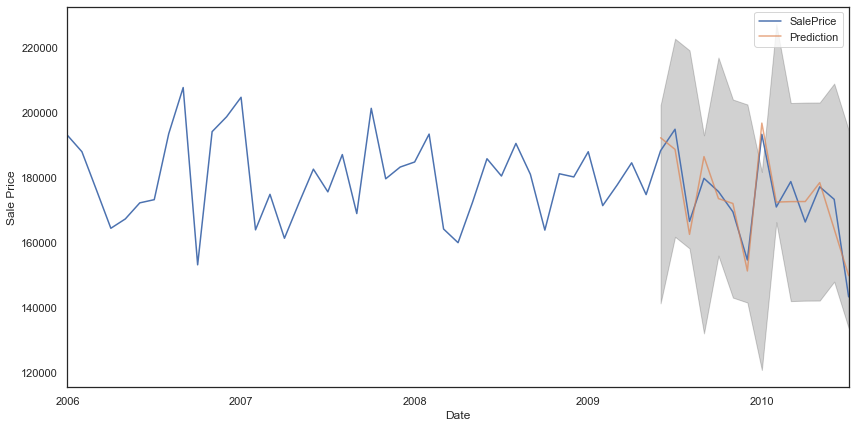

arima: (0, 1, 0), sarima: (1, 0, 1, 11), aic: 935.5391029150369, rmse = 17916.988820348208


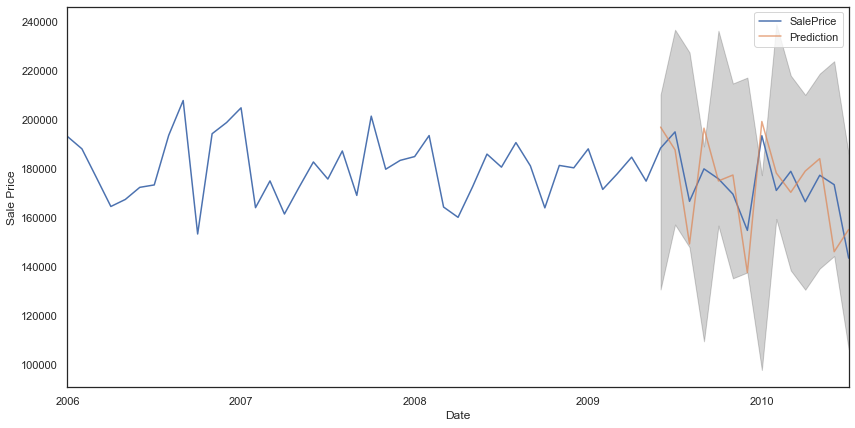

arima: (0, 1, 0), sarima: (1, 1, 0, 11), aic: 729.5956189277707, rmse = 21928.113235405683


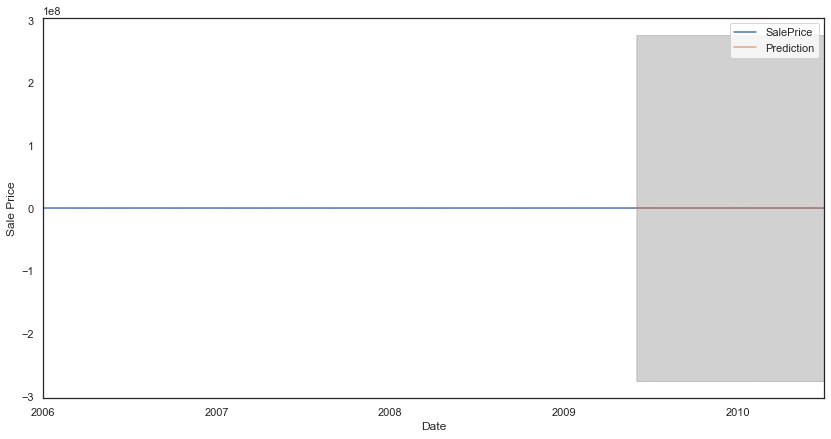

arima: (0, 1, 0), sarima: (1, 1, 1, 11), aic: 1226.2919539138697, rmse = 21604.42707216963


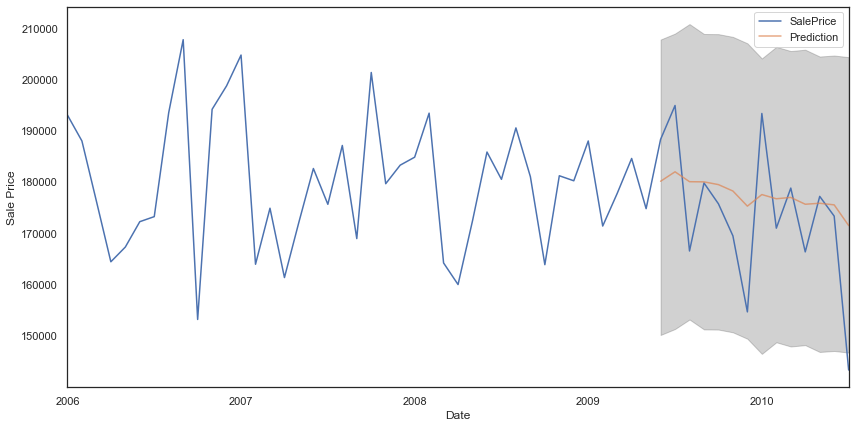

arima: (0, 1, 1), sarima: (0, 0, 0, 11), aic: 1145.1289941915975, rmse = 14007.511204305554


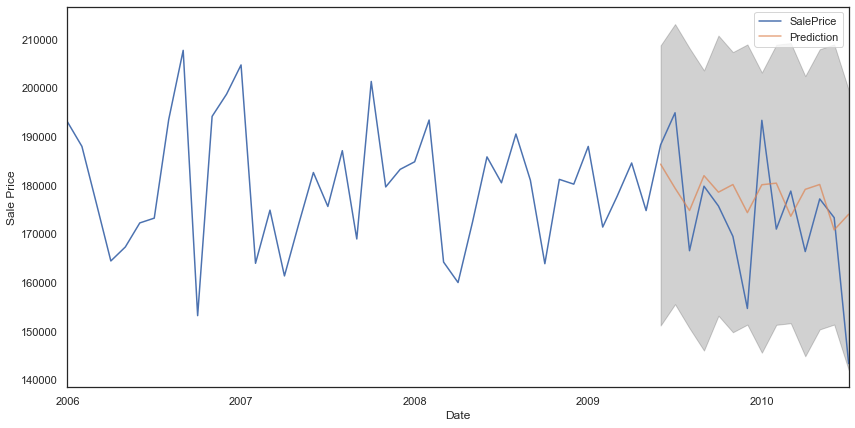

arima: (0, 1, 1), sarima: (0, 0, 1, 11), aic: 890.6078457309529, rmse = 13213.968891175073


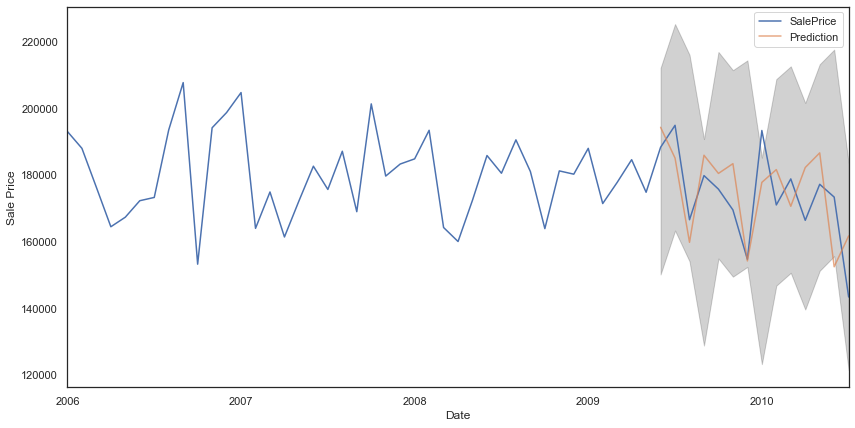

arima: (0, 1, 1), sarima: (0, 1, 0, 11), aic: 917.883797366475, rmse = 16331.498440228672


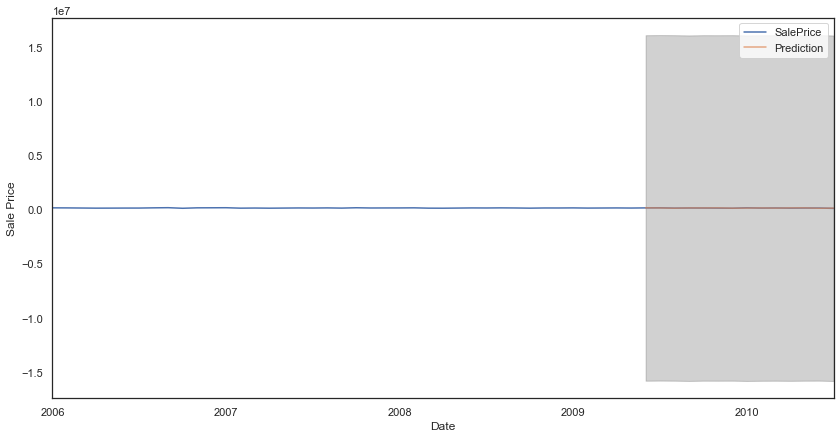

arima: (0, 1, 1), sarima: (0, 1, 1, 11), aic: 1015.8883835747862, rmse = 15424.528197091118


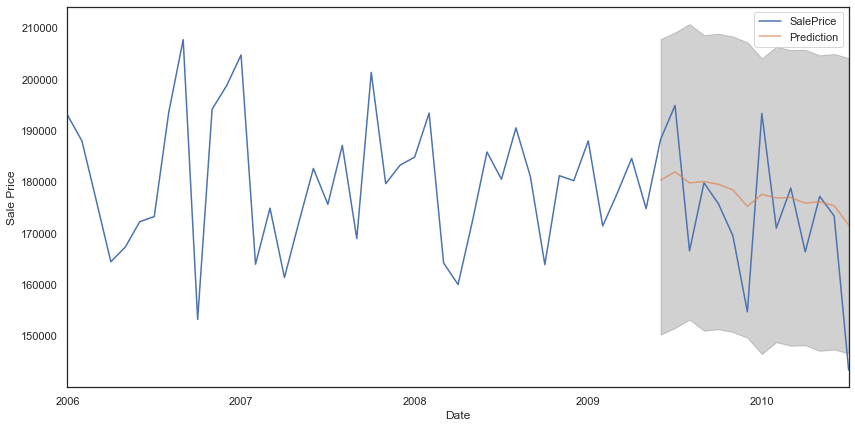

arima: (0, 1, 1), sarima: (1, 0, 0, 11), aic: 941.5983004977418, rmse = 13986.500457965109


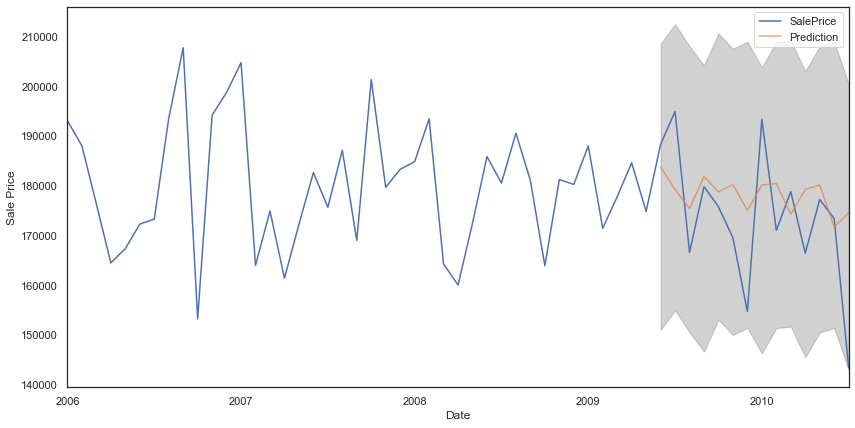

arima: (0, 1, 1), sarima: (1, 0, 1, 11), aic: 892.5030649867934, rmse = 13330.604137134645


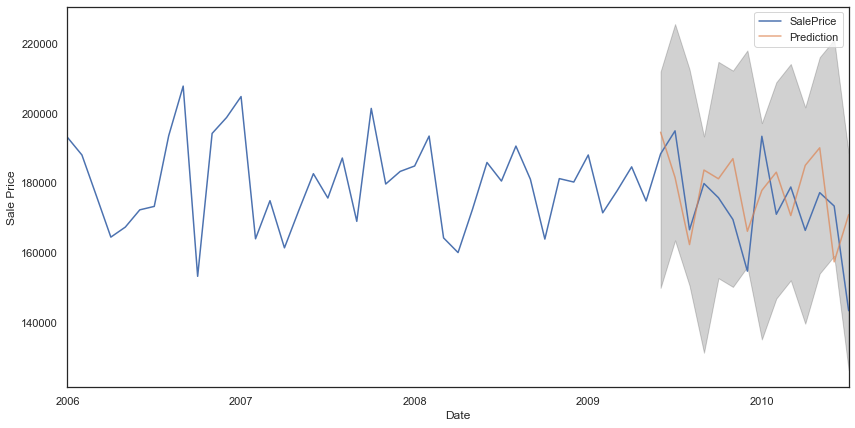

arima: (0, 1, 1), sarima: (1, 1, 0, 11), aic: 713.14172265156, rmse = 15086.005707822456


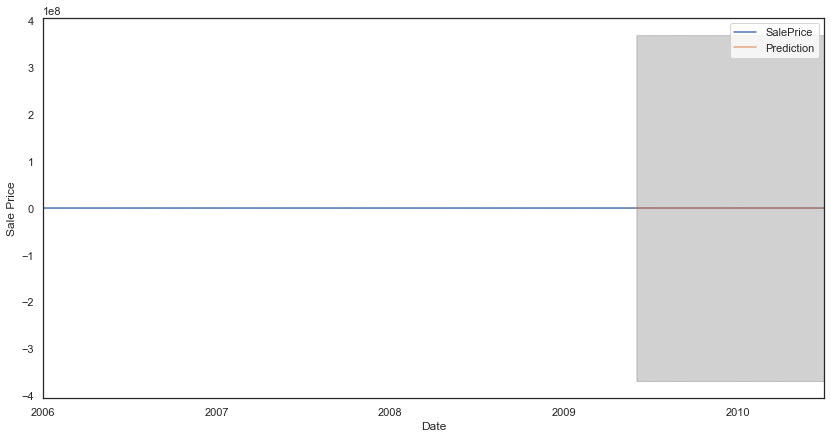

arima: (0, 1, 1), sarima: (1, 1, 1, 11), aic: 1206.201310418405, rmse = 15042.544062506817


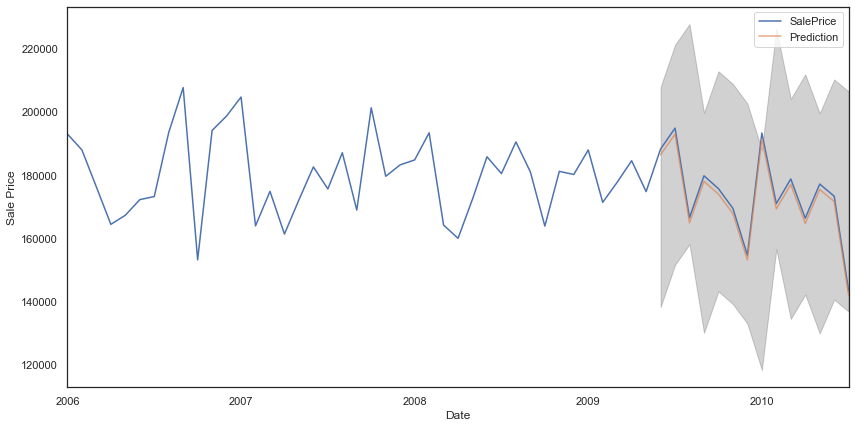

arima: (1, 0, 0), sarima: (0, 0, 0, 11), aic: 1214.068859410408, rmse = 18166.726034932282


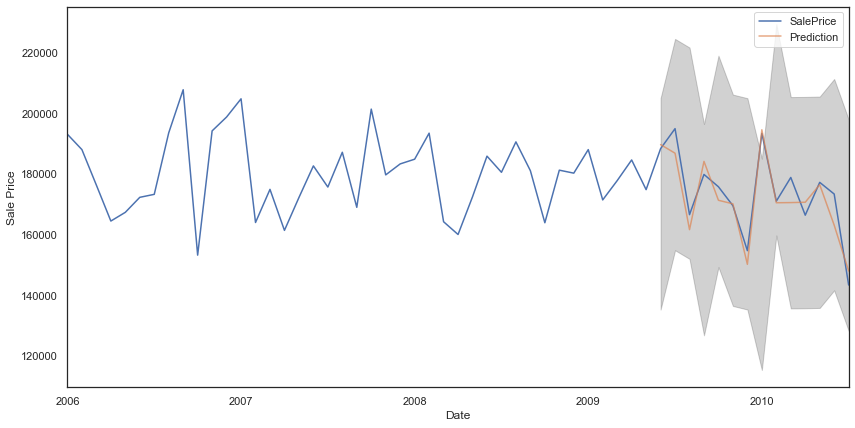

arima: (1, 0, 0), sarima: (0, 0, 1, 11), aic: 958.1715869452634, rmse = 17643.646407138174


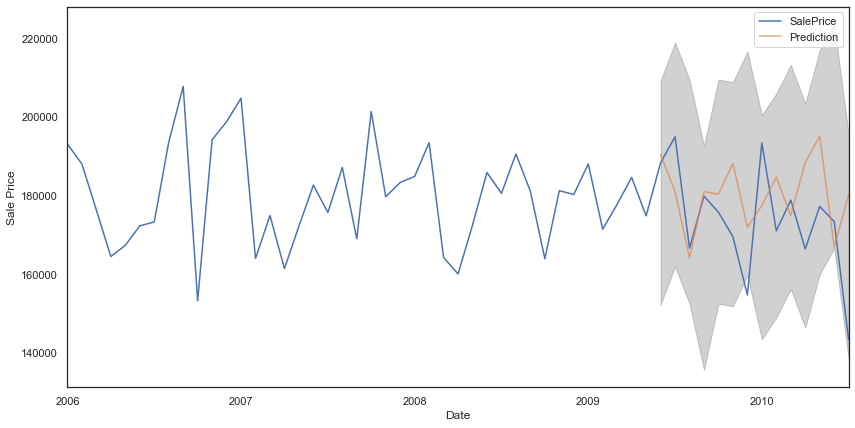

arima: (1, 0, 0), sarima: (0, 1, 0, 11), aic: 950.3040185671271, rmse = 15938.71663910235


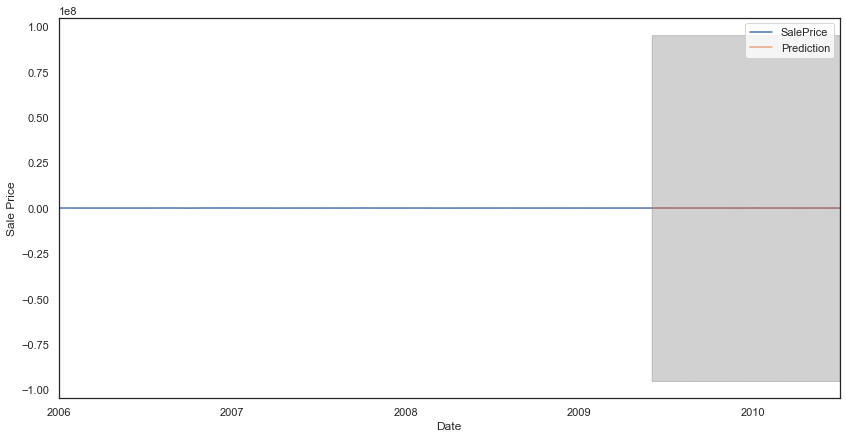

arima: (1, 0, 0), sarima: (0, 1, 1, 11), aic: 1197.513056824901, rmse = 15938.716639102742


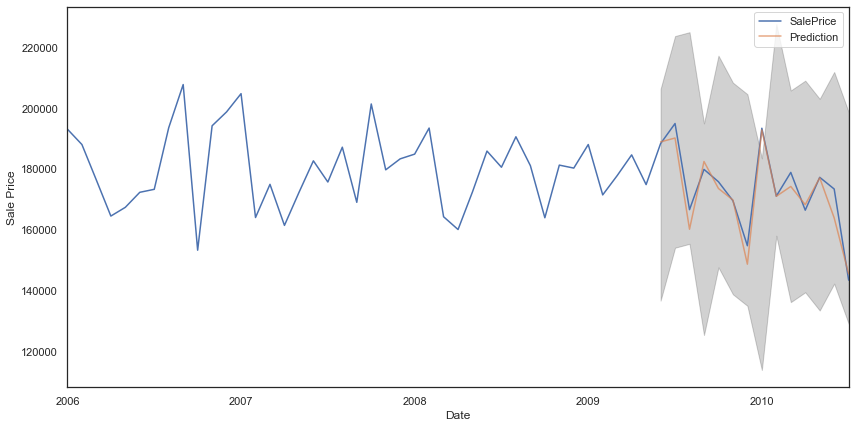

arima: (1, 0, 0), sarima: (1, 0, 0, 11), aic: 959.728284767471, rmse = 18257.00565441957


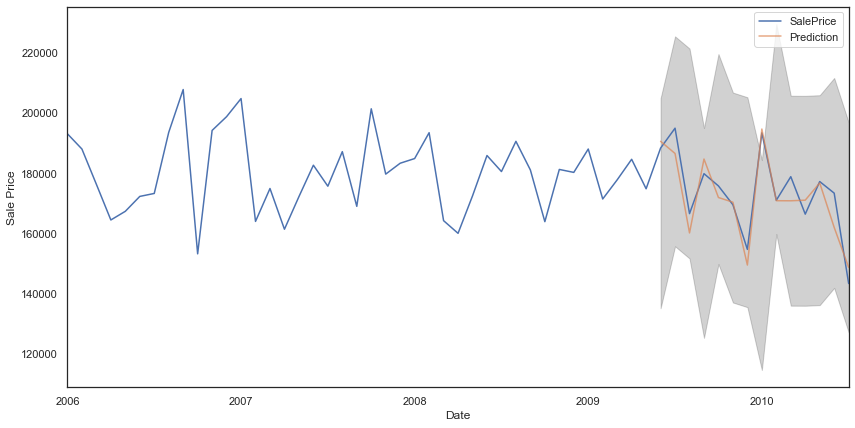

arima: (1, 0, 0), sarima: (1, 0, 1, 11), aic: 959.895385688966, rmse = 17793.09977553948


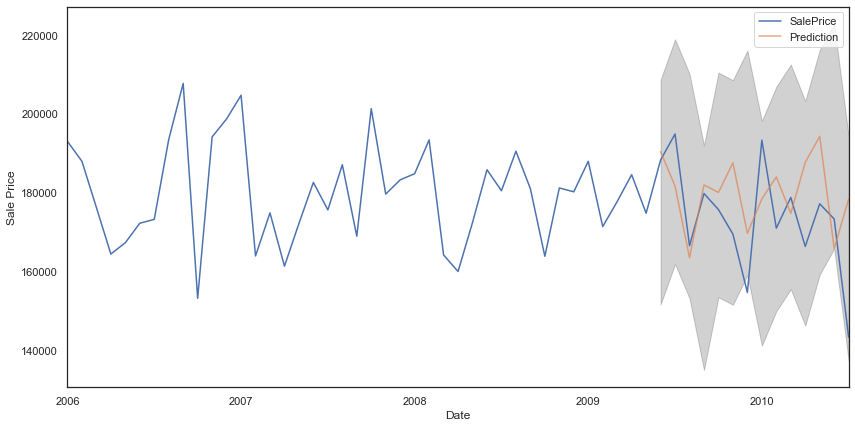

arima: (1, 0, 0), sarima: (1, 1, 0, 11), aic: 711.3487465966034, rmse = 15999.628326205939


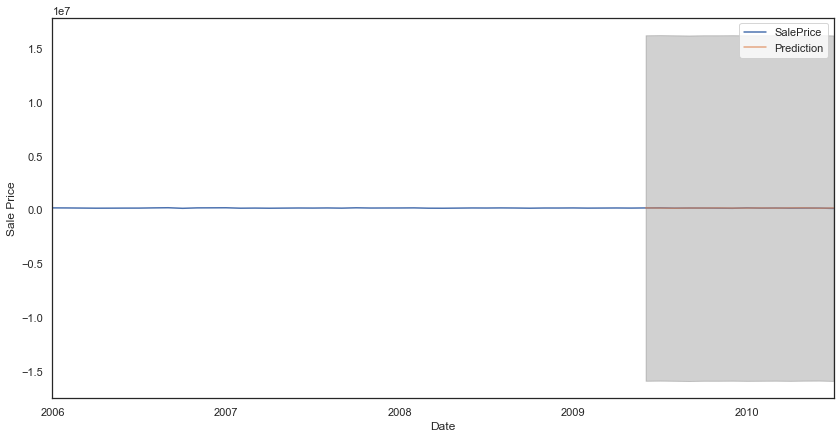

arima: (1, 0, 0), sarima: (1, 1, 1, 11), aic: 1085.7212786381024, rmse = 15687.236876906889


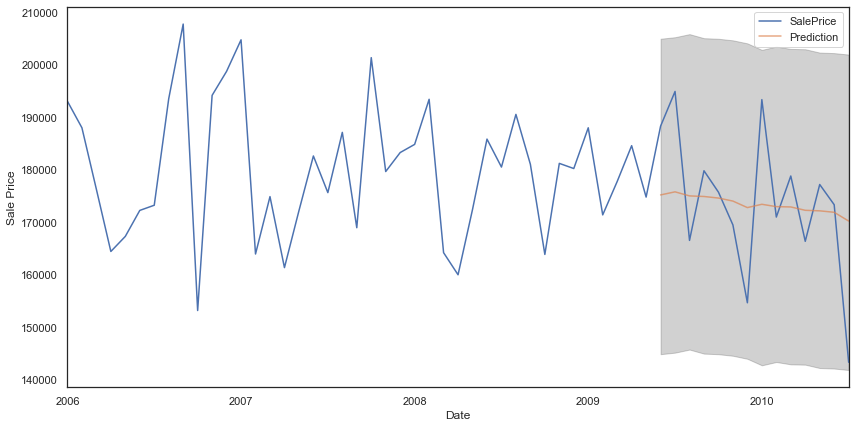

arima: (1, 0, 1), sarima: (0, 0, 0, 11), aic: 1167.7244595282973, rmse = 13154.641873254383


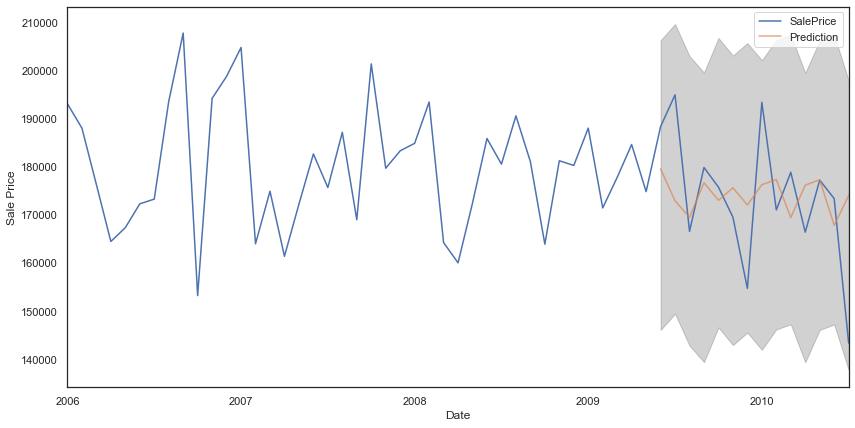

arima: (1, 0, 1), sarima: (0, 0, 1, 11), aic: 914.7399183876943, rmse = 12218.306196381944


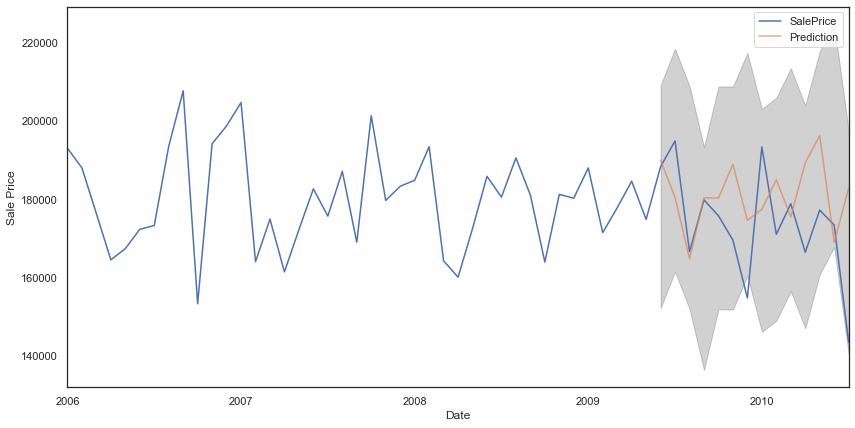

arima: (1, 0, 1), sarima: (0, 1, 0, 11), aic: 929.4138310064449, rmse = 16143.959627993421


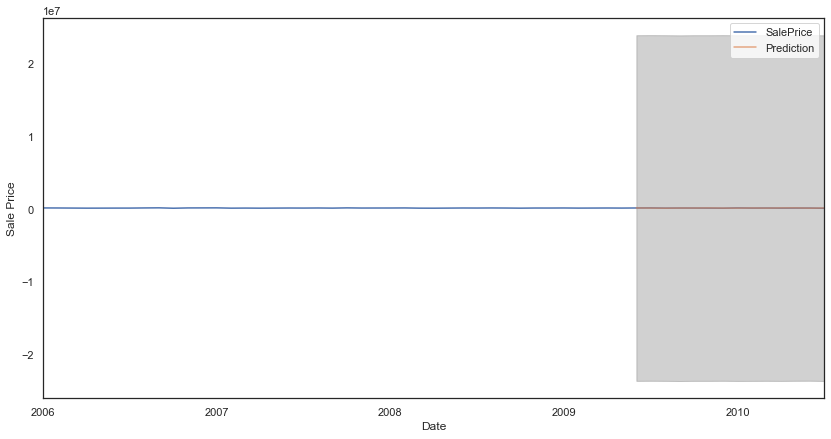

arima: (1, 0, 1), sarima: (0, 1, 1, 11), aic: 1076.3140727908897, rmse = 15984.879023435094


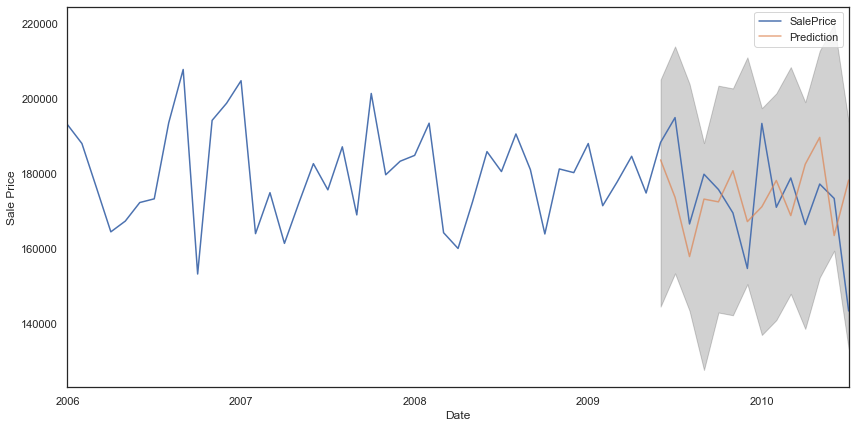

arima: (1, 0, 1), sarima: (1, 0, 0, 11), aic: 950.4198268262725, rmse = 14453.67220766912


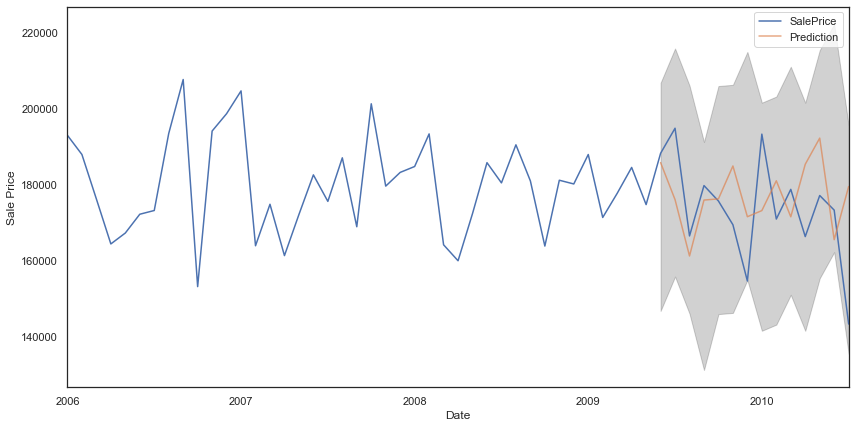

arima: (1, 0, 1), sarima: (1, 0, 1, 11), aic: 931.3710094190271, rmse = 14740.065430579187


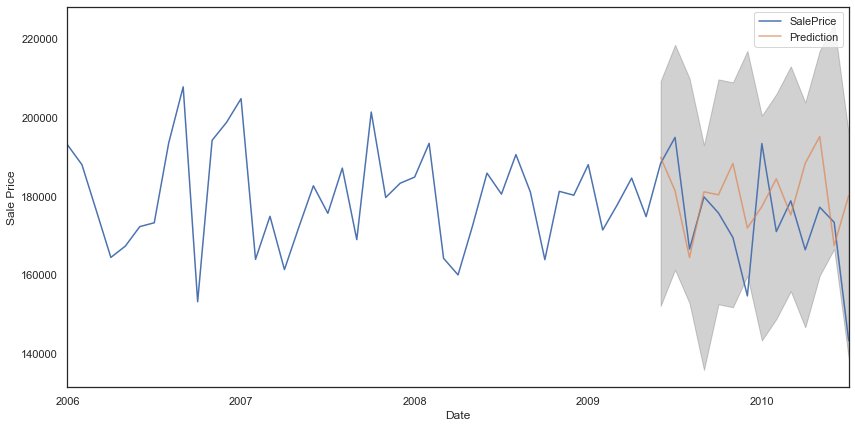

arima: (1, 0, 1), sarima: (1, 1, 0, 11), aic: 713.4060784541722, rmse = 16048.136548929057


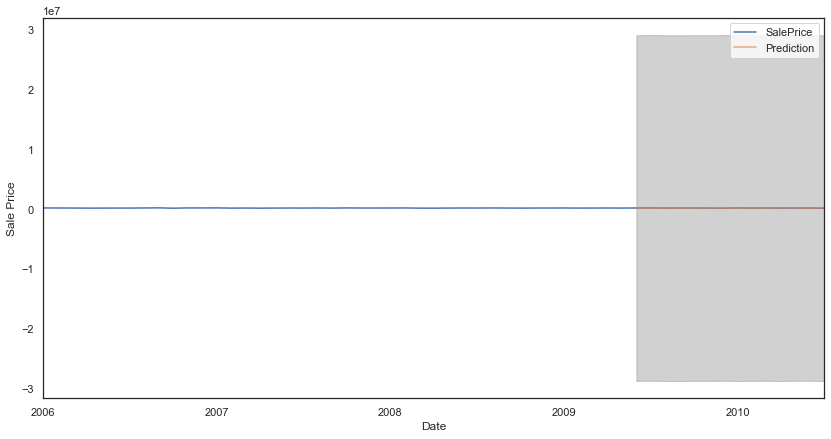

arima: (1, 0, 1), sarima: (1, 1, 1, 11), aic: 1090.4093509933634, rmse = 15739.142434902911


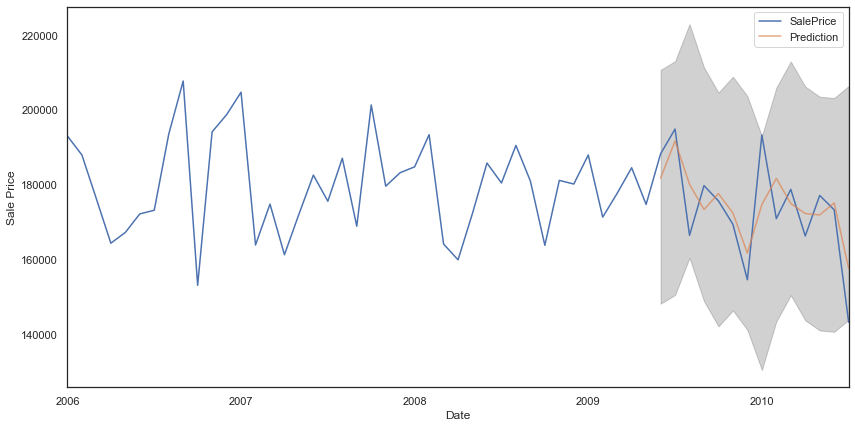

arima: (1, 1, 0), sarima: (0, 0, 0, 11), aic: 1179.9658744789785, rmse = 15596.169318375572


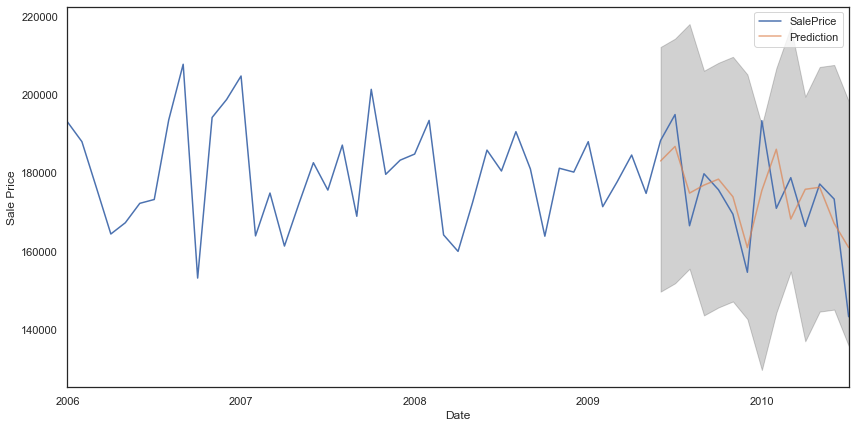

arima: (1, 1, 0), sarima: (0, 0, 1, 11), aic: 925.6058710429099, rmse = 14097.87553363804


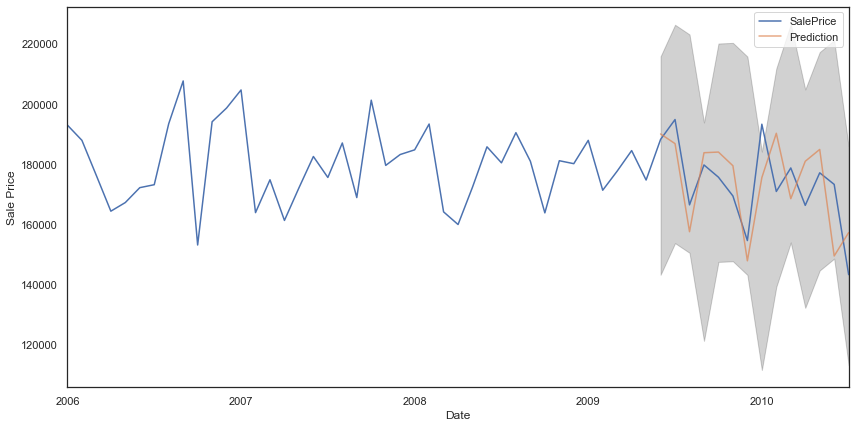

arima: (1, 1, 0), sarima: (0, 1, 0, 11), aic: 948.609679218057, rmse = 17547.57935684492


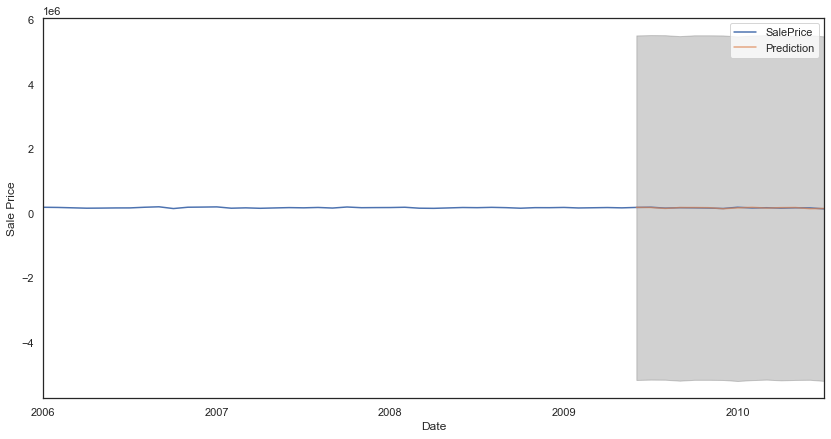

arima: (1, 1, 0), sarima: (0, 1, 1, 11), aic: 981.6706207082149, rmse = 17547.579356844868


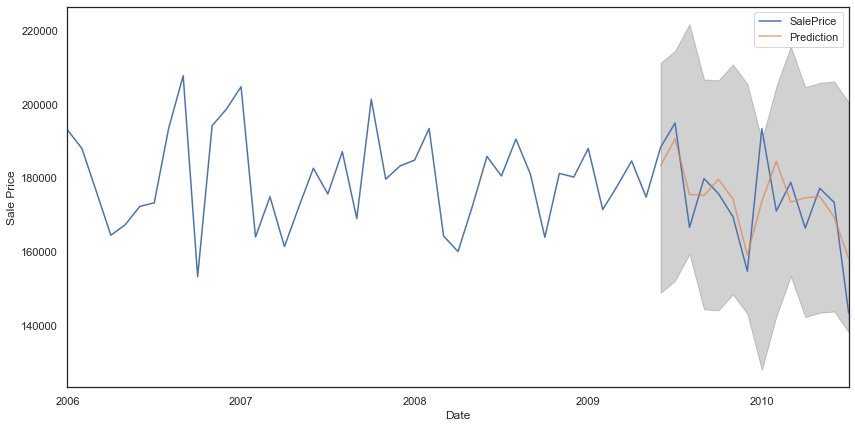

arima: (1, 1, 0), sarima: (1, 0, 0, 11), aic: 927.841860249913, rmse = 15199.593666131326


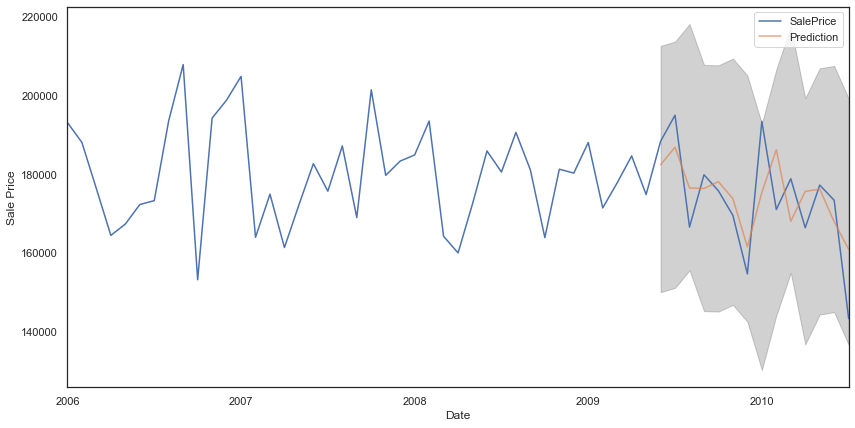

arima: (1, 1, 0), sarima: (1, 0, 1, 11), aic: 927.5266238342622, rmse = 14057.91776633241


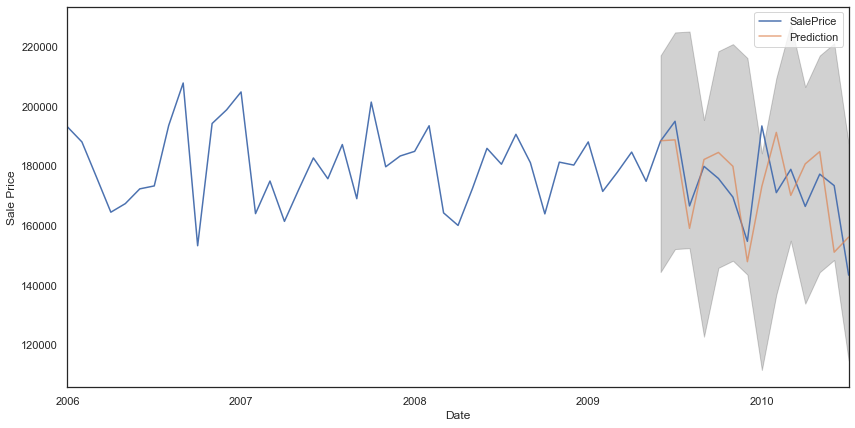

arima: (1, 1, 0), sarima: (1, 1, 0, 11), aic: 702.3895090419361, rmse = 17646.358888270854


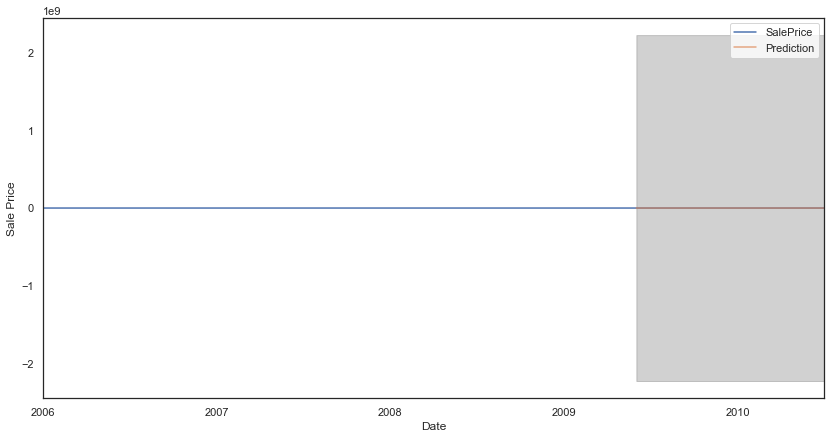

arima: (1, 1, 0), sarima: (1, 1, 1, 11), aic: 1357.6425970213056, rmse = 17194.143765200464


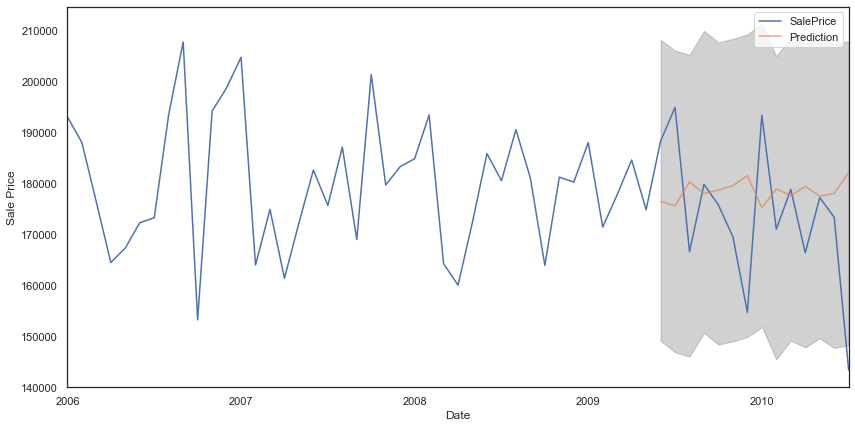

arima: (1, 1, 1), sarima: (0, 0, 0, 11), aic: 1141.5203009901197, rmse = 13963.888003449392


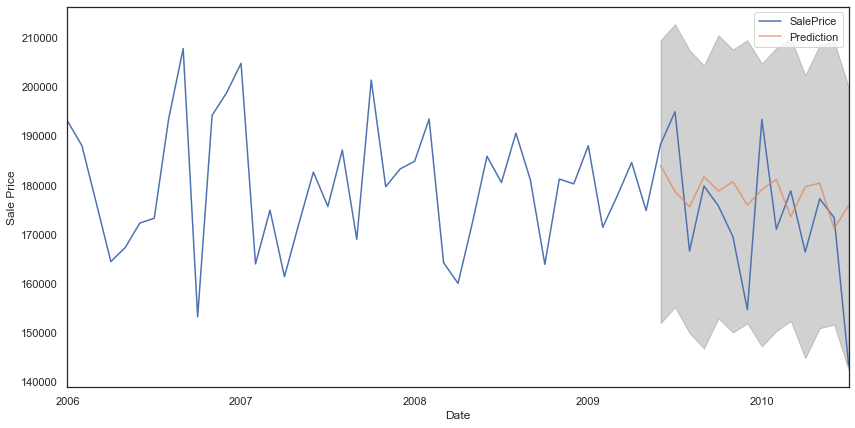

arima: (1, 1, 1), sarima: (0, 0, 1, 11), aic: 892.4741470686239, rmse = 13077.388023991563


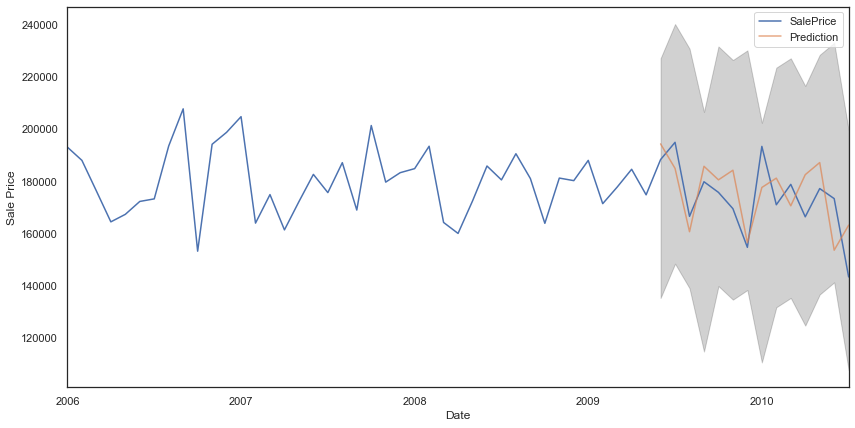

arima: (1, 1, 1), sarima: (0, 1, 0, 11), aic: 929.4545790475642, rmse = 16034.301735302763


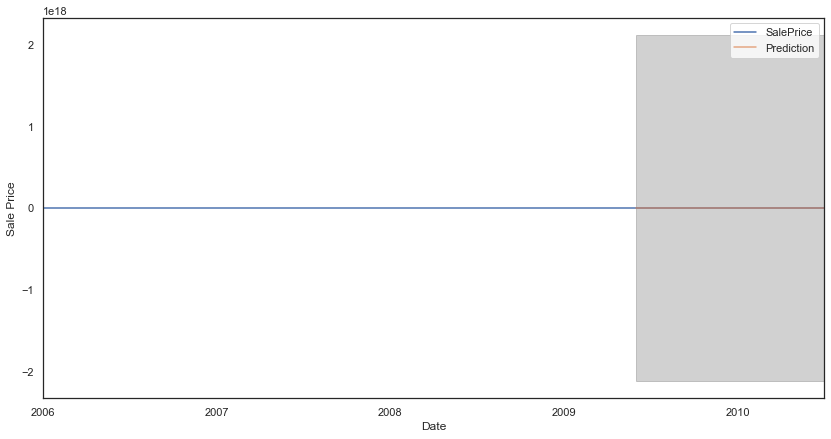

arima: (1, 1, 1), sarima: (0, 1, 1, 11), aic: 2554.5952544184893, rmse = 136005392.69789854


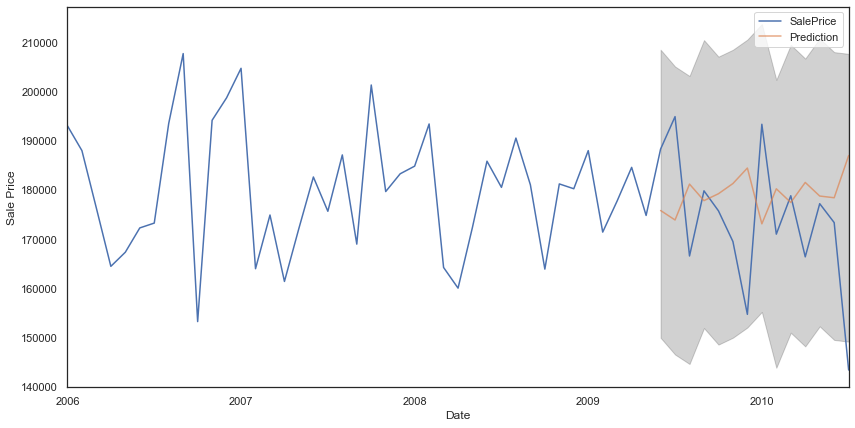

arima: (1, 1, 1), sarima: (1, 0, 0, 11), aic: 917.6616529480824, rmse = 14126.028923693479


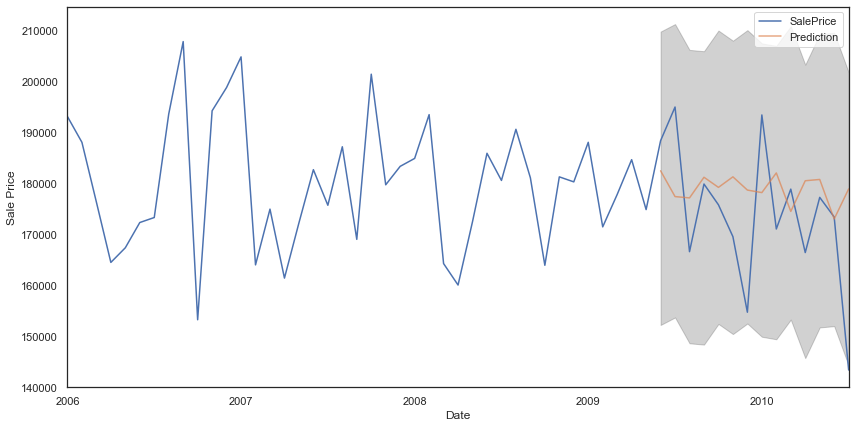

arima: (1, 1, 1), sarima: (1, 0, 1, 11), aic: 894.1754141744065, rmse = 13215.812374208697


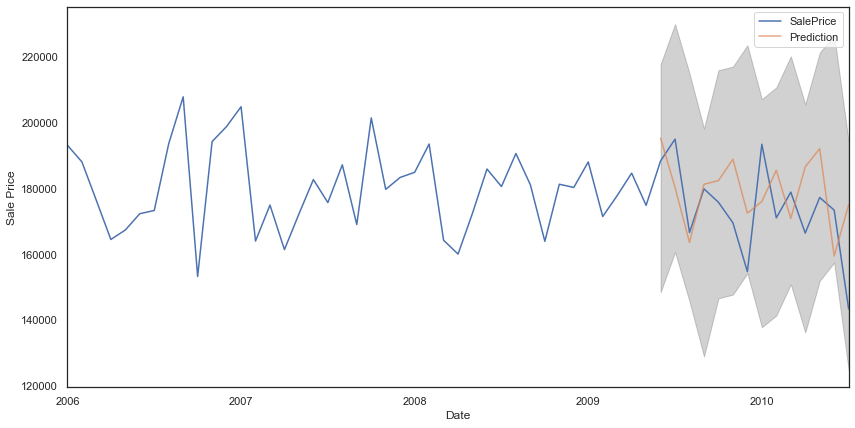

arima: (1, 1, 1), sarima: (1, 1, 0, 11), aic: 692.3052891275116, rmse = 14778.990033138967


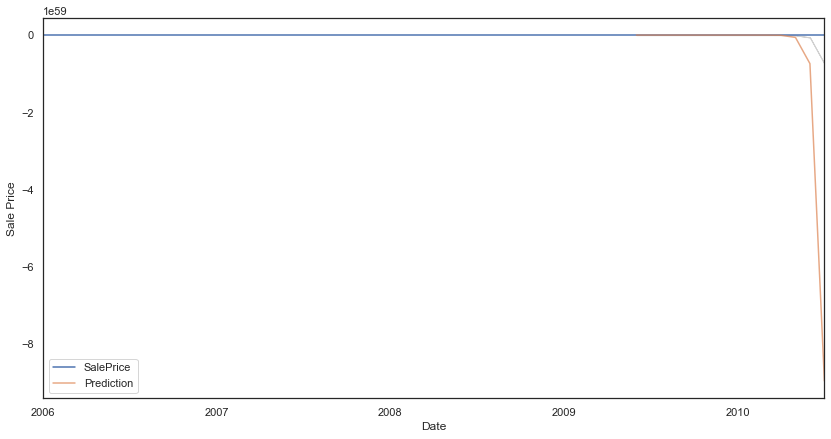

arima: (1, 1, 1), sarima: (1, 1, 1, 11), aic: 10.0, rmse = 1.9841746414659187e+58


In [114]:
import math
for arima, sarima, aic in results:
    
    mod = sm.tsa.statespace.SARIMAX(df,
                                order=arima,
                                seasonal_order=sarima,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                trend_offset=2)
    result = mod.fit(disp=False)

    pred = result.get_prediction(start=pd.to_datetime('2009-06-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = df.plot(label='Observed')

    predicted_mean = pred.predicted_mean.shift(-1)
    predicted_mean.iloc[13] = result.forecast(1)
    predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 7))
    
    mse = ((df['2009-06-01':].squeeze() - pred.predicted_mean) ** 2).mean()
    
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')

    plt.legend()
    plt.show()
    print(f'arima: {arima}, sarima: {sarima}, aic: {aic}, rmse = {mse ** 0.5}')

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

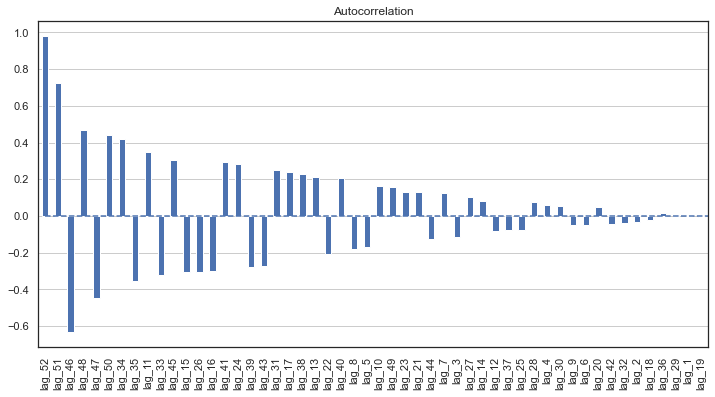

In [114]:

# auto_cor = sales.groupby("Date")["Weekly_Sales"].sum()
# auto_cor = pd.DataFrame(auto_cor)
# auto_cor.columns = ["y"]

df2 = df.copy()
# Adding the lag of the target variable from 1 steps back up to 52 (due to a seasonality at the end of the year)
for i in range(1, 53):
    df2["lag_{}".format(i)] = df2.SalePrice.shift(i)

# Compute autocorrelation of the series and its lags
lag_corr = df2.corr()
lag_corr = lag_corr.iloc[1:,0]
lag_corr.columns = ["corr"]
order = lag_corr.abs().sort_values(ascending = False)
lag_corr = lag_corr[order.index]

# Plot the Autocorrelation
plt.figure(figsize=(12, 6))
lag_corr.plot(kind='bar')
plt.grid(True, axis='y')
plt.title("Autocorrelation")
plt.hlines(y=0, xmin=0, xmax=len(lag_corr), linestyles='dashed')

In [107]:
import pmdarima as pm

In [122]:
stepwise_model = pm.auto_arima(df.iloc[:].values, start_p=1, start_q=1,
                               max_p=20, max_q=20, m=52,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=54.90 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=46.491, Time=2.17 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=35.91 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=20.54 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=5.26 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=4.21 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=46.911, Time=26.37 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=47.931, Time=1.18 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=48.884, Time=0.94 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=48.086, Time=15.16 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=46.411, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[52] intercept   : AIC=48.145, Time=7.01 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(0,1,0)(1,1,1)[52] intercept   : AIC=49.778, Time=6.70 sec
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=49.931, Time=1.06